# Import required packages for EDA, statistical analysis and Visualization

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/Users/admin/Desktop/AXA')
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wolta.data_tools import col_types
from wolta.data_tools import make_numerics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# upload  dataset provided by AXA Health

In [3]:
df=pd.read_csv('depression_data.csv')

# This is a use case of class imbalance, as there are 69.6% of the total population representing to people with "No Mental Illness" whereas only 30.4% represneting to pouplation with "Mental Illness"

In [7]:
df['History of Mental Illness'].value_counts()

History of Mental Illness
No     287943
Yes    125825
Name: count, dtype: int64

In [11]:
Target_column_mapping = {'Yes': 1, 'No': 0}
df['History of Mental Illness'] = df['History of Mental Illness'].map(Target_column_mapping)

# No duplicate rows in the dataset

In [6]:
df.duplicated().sum() 

0

# No null values in the dataset 

In [8]:
df.isnull().sum() 

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

# This is a use case of  class imbalance, as there are 69.6% of the total population representing to people with "No Mental Illness" whereas only 30.4% represneting to pouplation with "Mental Illness"

# Mapping the target column for easier interpretation(History of Mental Illness) as Yes to 1 (have  history of mental illnness) and No:1(no history of mental illness)

In [12]:
Target_column_mapping = {'Yes': 1, 'No': 0}
df['History of Mental Illness'] = df['History of Mental Illness'].map(Target_column_mapping)

# Univariate feature analysis on Age and Income to see if there is any outliers based on the kernel density estimate 
# Based on the distribution of Age this looks like age feature distribution doesn't contain outliers while Income feature shows there is outliers based on kernel density estimate more towards very high income of 170,000+

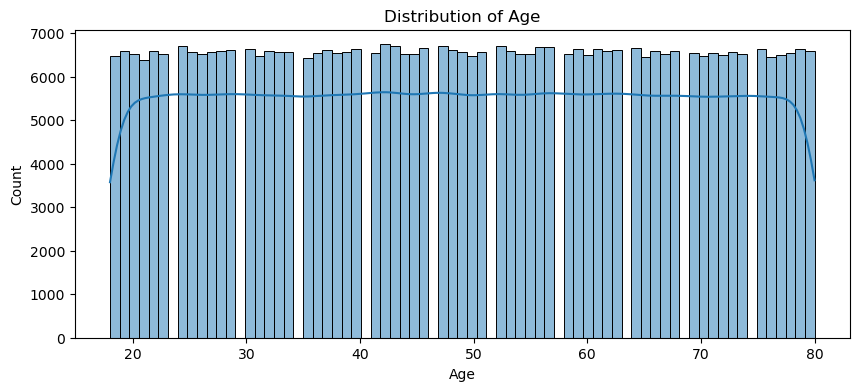

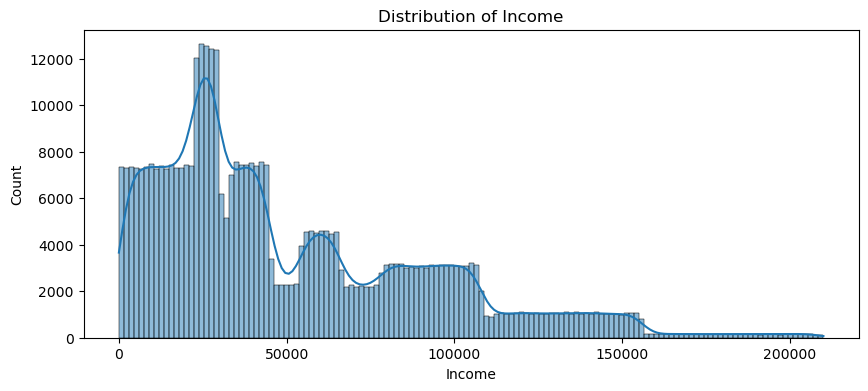

In [14]:
numerical_features = ['Age','Income']
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=feature, kde=True)
    plt.title('Distribution of ' + feature)
    plt.show()

# To check pearson coorelation firstly the distribution has to normal distribuition (bell shaped curve). Based on the heatmap below this looks like there is no positive, no negative relationship between the numerical features vs Target("History of Mental Illness")

<Axes: >

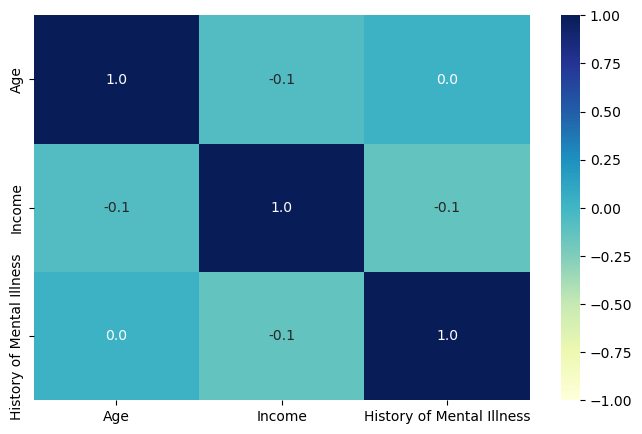

In [16]:
feature_list = ['Age', 'Income', 'History of Mental Illness']
fig_dims = (8,5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(df[feature_list].corr(method='pearson'),cmap="YlGnBu",vmin=-1,annot=True,fmt='.1f',ax=ax)

# (Feature engineering)-In  order to reduce the number of unique values of a variable binning is the best option . This converts continuos variables to discrete bins. As this helps to capture non-linear relationships between a feature and Target . Furthermore, this will result in creating two new additional features i.e. Income_Range and Age_bin. This will further simplify the complex transformations and improve model performance.

In [18]:
def income_range(Income):
    if Income<20000:
        return 'Low Income'
    elif (Income > 20000) & (Income<100000):
        return 'Standard Income'
    elif Income >100000:
        return 'High Income'
df['Income_Range']=df['Income'].apply(income_range) 
df['Age_bin'] = pd.cut(df['Age'], bins=[-np.inf, 18, 35, 50, 65, np.inf], labels=['Under 18', '18-35', '36-50', '51-65', '65+'])

# Name column is dropped mainly as this is a privacy concern and its not relevant for model interpretation

In [20]:
df.drop(columns=["Name"],inplace=True) 

<Axes: xlabel='History of Mental Illness'>

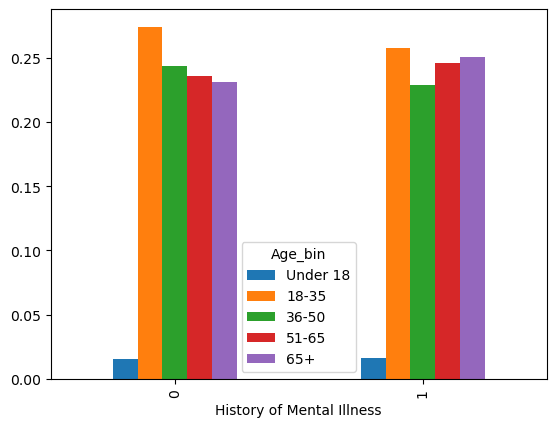

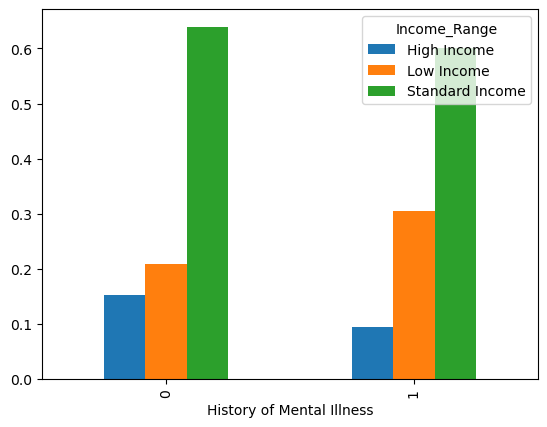

In [21]:
# Bivariate Analysis 
SS = pd.crosstab(df['History of Mental Illness'],df['Age_bin'])
SS.div(SS.sum(1),axis=0).plot(kind='bar',stacked=False)

SS = pd.crosstab(df['History of Mental Illness'],df['Income_Range'])
SS.div(SS.sum(1),axis=0).plot(kind='bar',stacked=False)

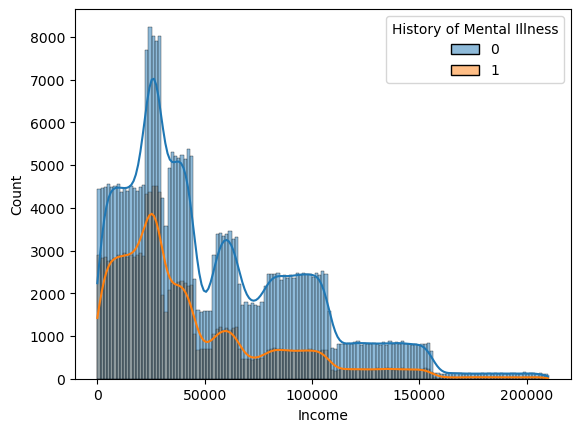

In [22]:
sns.histplot(data = df, x = "Income", kde = True, hue = "History of Mental Illness");

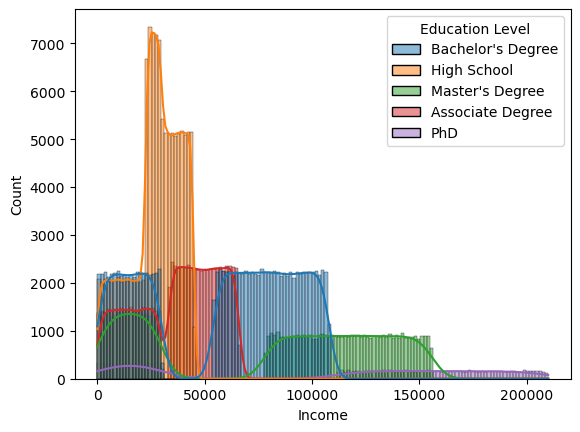

In [23]:
sns.histplot(data = df, x = "Income", kde = True, hue = "Education Level");

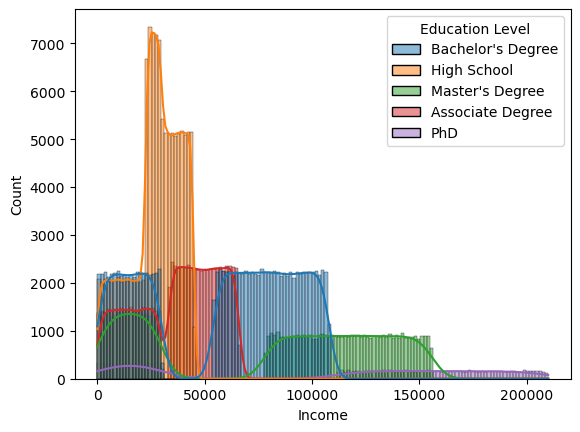

In [24]:
sns.histplot(data = df, x = "Income", kde = True, hue = "Education Level");

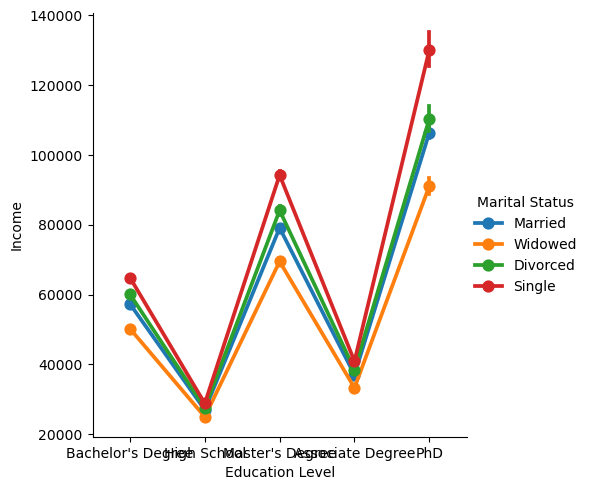

In [25]:
sns.catplot(data = df, x = "Education Level", y = "Income", hue = "Marital Status", kind = "point");

# KDE plot between Income and Mariatal Status

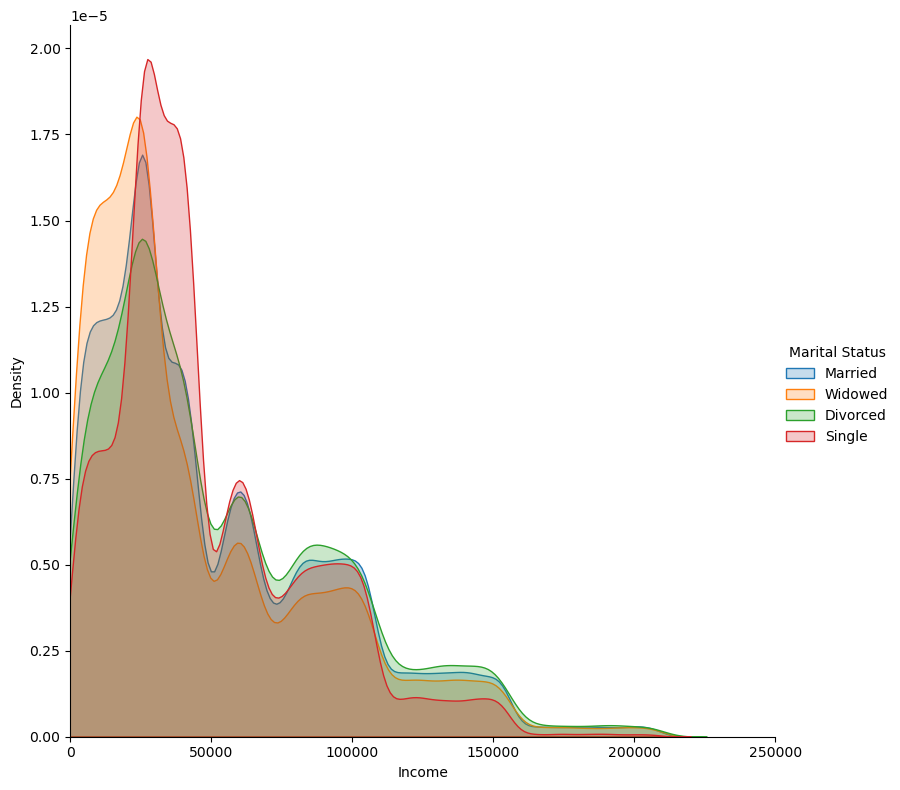

In [27]:
sns.FacetGrid(data = df,
              hue = "Marital Status",
              height = 8,
              xlim = (0, 250000)).map(sns.kdeplot, "Income", fill = True).add_legend();

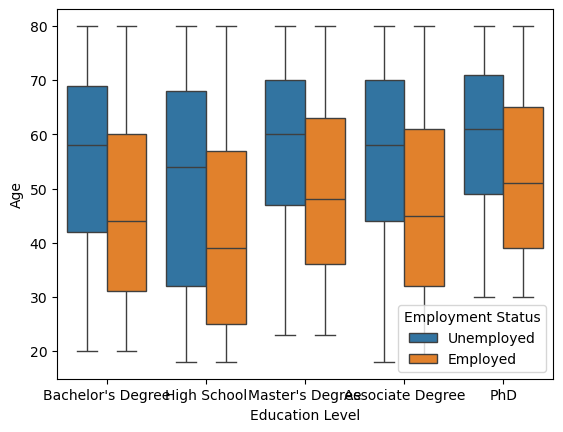

In [28]:
sns.boxplot(data = df,
            x = "Education Level",
            y = "Age",
            hue = "Employment Status");

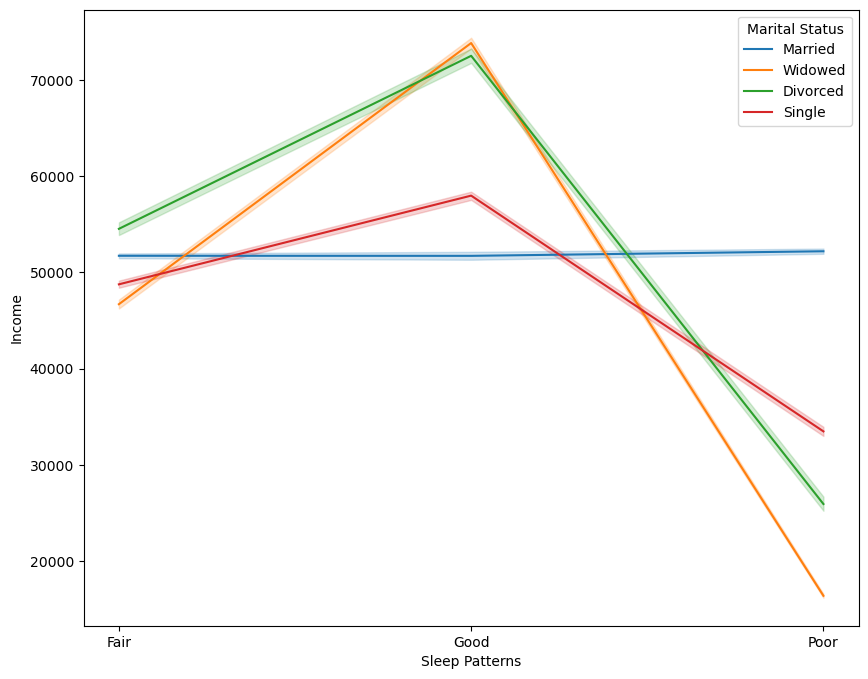

In [29]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = df,
             x = "Sleep Patterns",
             y = "Income",
             hue = "Marital Status");

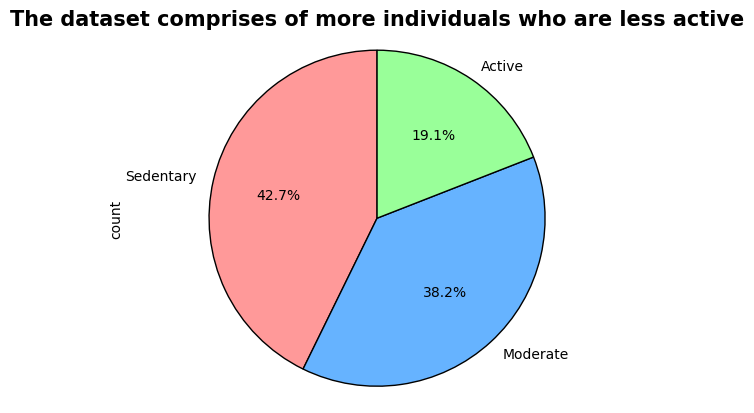

In [30]:
df['Physical Activity Level'].value_counts().plot(kind = 'pie' , autopct= '%0.1f%%', 
                                                  colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],
                                                  shadow=False,startangle=90, wedgeprops={'edgecolor': 'black'} )
plt.title('The dataset comprises of more individuals who are less active',fontsize=15,weight='bold')
plt.axis('equal')  
plt.show()

# Sedentary to Moderate activity level individuals have the risk of having mental illness

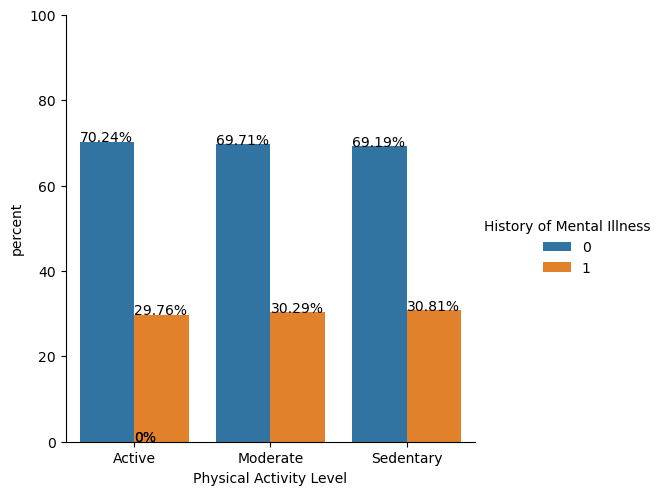

In [32]:
x,y = 'Physical Activity Level', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# Under 18 and 65+  age group individual are likely to mental illness

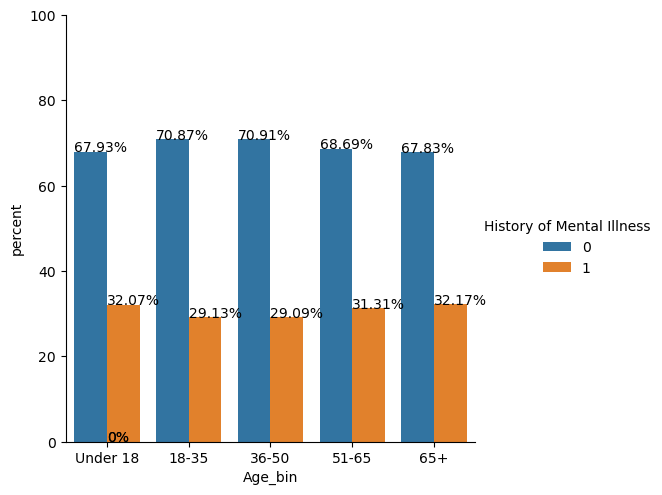

In [34]:
x,y = 'Age_bin', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [ ]:
sns.countplot(data = df,
              x = "Smoking Status",
              hue = "Smoking Status",
              order = df["Smoking Status
              
              
              value_counts().index,
              palette = "Set1").set_title("Non-Smokers are more than Current and former smokers",weight='bold');

# Poor sleep cycle can be a good indicator of having mental illness

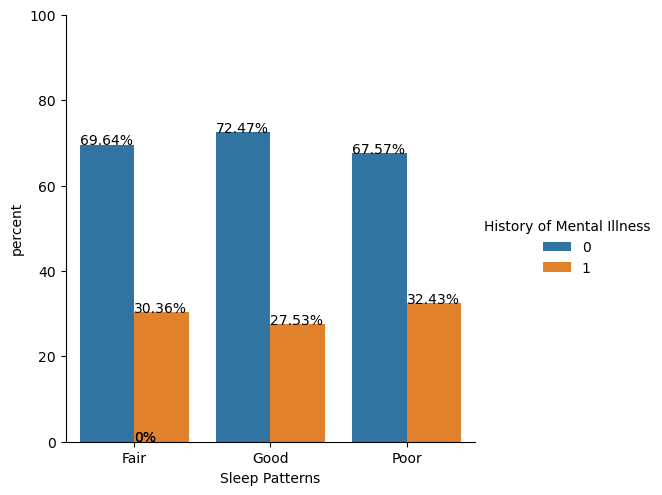

In [37]:
x,y = 'Sleep Patterns', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# Widowed individuals are more likely to have more chances of Mental illness

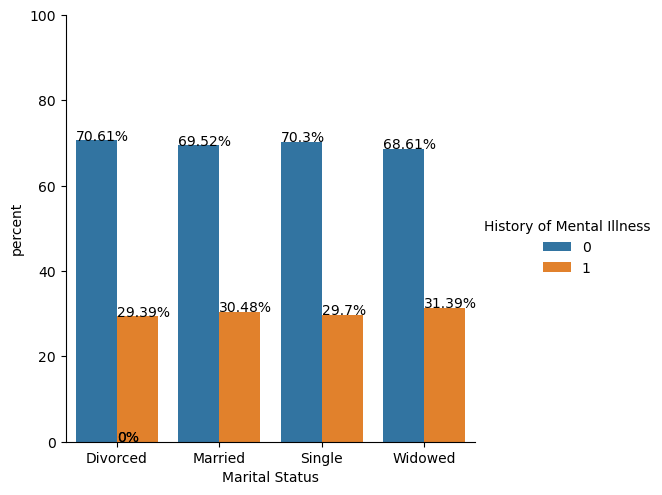

In [39]:
x,y = 'Marital Status', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# People with high alcohol intake are more likely to have Mental illness

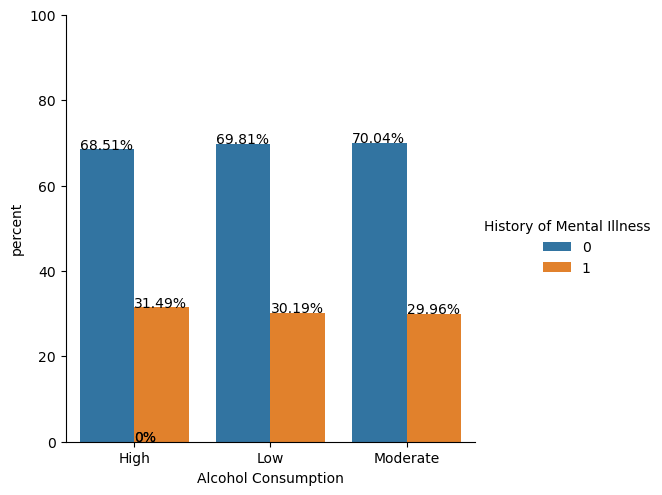

In [41]:
x,y = 'Alcohol Consumption', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

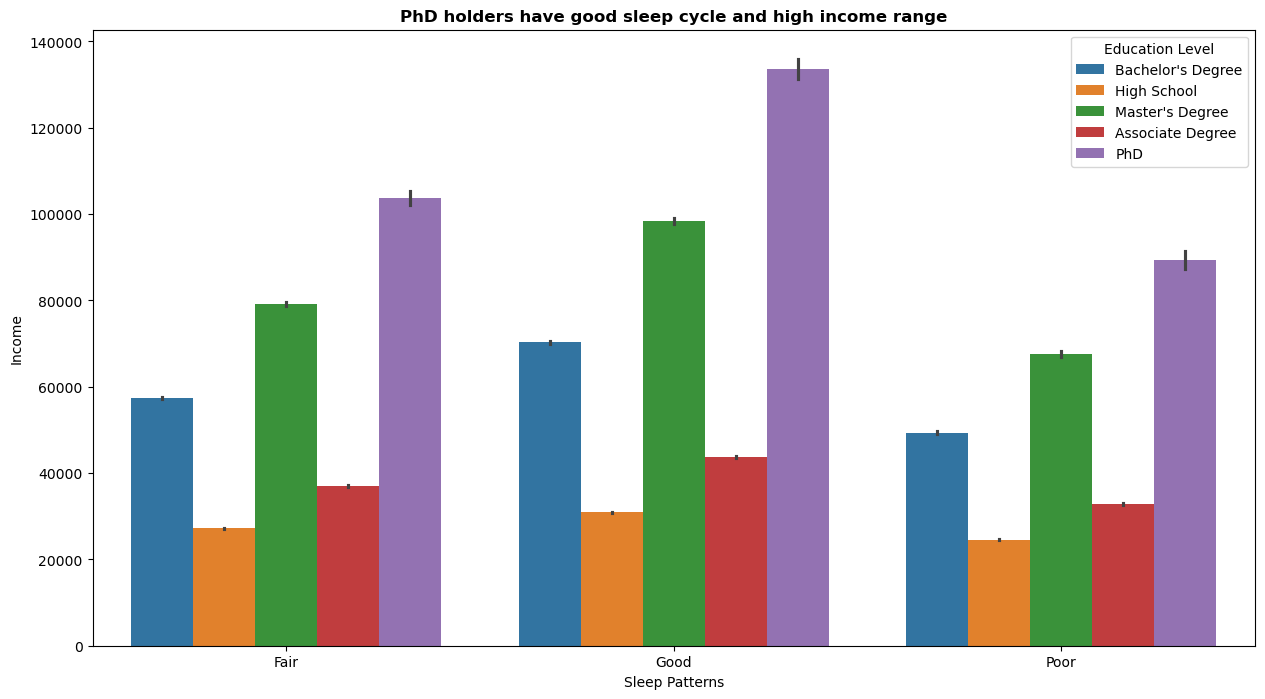

In [42]:
plt.figure(figsize = (15, 8))
sns.barplot(data = df,
            x = "Sleep Patterns",
            y = "Income",
            hue = "Education Level").set_title("PhD holders have good sleep cycle and high income range",weight='bold');

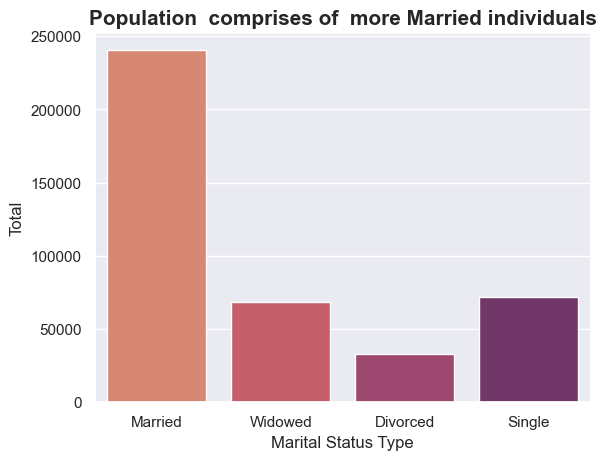

In [43]:
sns.set_theme(style="darkgrid")
sns.countplot(x="Marital Status", data=df, palette="flare")
plt.xlabel('Marital Status Type')
plt.ylabel('Total')
plt.title('Population  comprises of  more Married individuals',fontsize=15,weight='bold')
plt.show()

In [44]:
Sleep_Patterns_status=pd.DataFrame(df['Sleep Patterns'].value_counts())
Sleep_Patterns_status.rename_axis('Sleep Patterns',inplace=True)
Sleep_Patterns_status.columns=['Total Count']
Sleep_Patterns_status=Sleep_Patterns_status.reset_index()
Sleep_Patterns_status

,Sleep Patterns,Total Count
0,Fair,196789
1,Poor,129582
2,Good,87397


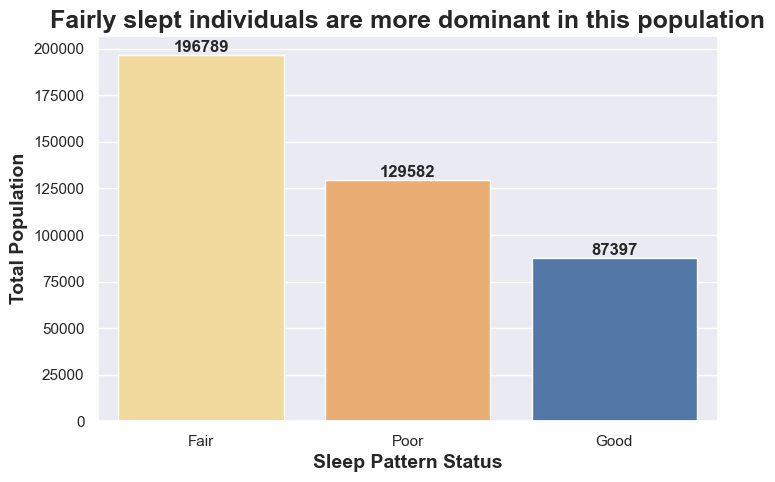

In [45]:
plt.figure(figsize=(8,5))
palette = ["#fee090", "#fdae61", "#4575b4", "#313695"]
bar=sns.barplot(x='Sleep Patterns',y='Total Count',data=Sleep_Patterns_status,palette=palette)

plt.title('Fairly slept individuals are more dominant in this population',fontsize=18,weight='bold')
plt.xlabel('Sleep Pattern Status',fontsize=14,weight='bold')
plt.ylabel('Total Population',fontsize=14,weight='bold')

for i in range(len(Sleep_Patterns_status)):
    plt.text(i,Sleep_Patterns_status['Total Count'][i] ,Sleep_Patterns_status['Total Count'][i],  
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

In [46]:
Alcohol_Consumption=pd.DataFrame(df['Alcohol Consumption'].value_counts())
Alcohol_Consumption.rename_axis('Alcohol Consumption',inplace=True)
Alcohol_Consumption.columns=['Total Count']
Alcohol_Consumption=Alcohol_Consumption.reset_index()
Alcohol_Consumption

,Alcohol Consumption,Total Count
0,Moderate,173440
1,Low,139250
2,High,101078


In [47]:
Employment_Status=pd.DataFrame(df['Employment Status'].value_counts())
Employment_Status.rename_axis('Employment Status',inplace=True)
Employment_Status.columns=['Total Count']
Employment_Status=Employment_Status.reset_index()
Employment_Status

,Employment Status,Total Count
0,Employed,265659
1,Unemployed,148109


# Unemployement can be a cause of mental illness 

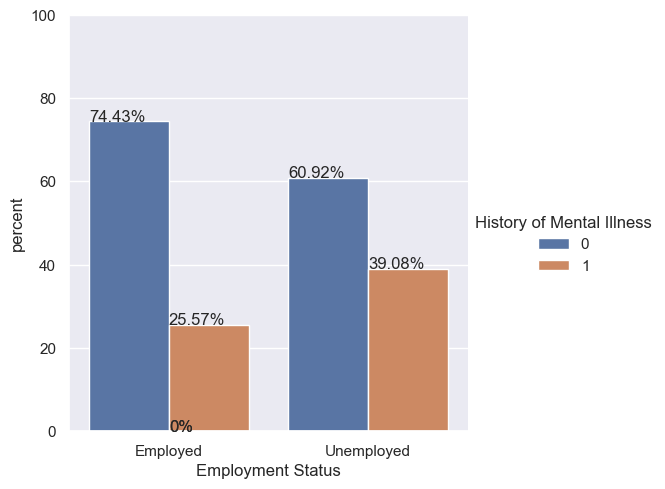

In [49]:
x,y = 'Employment Status', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# Poor diet can lead to mental illness

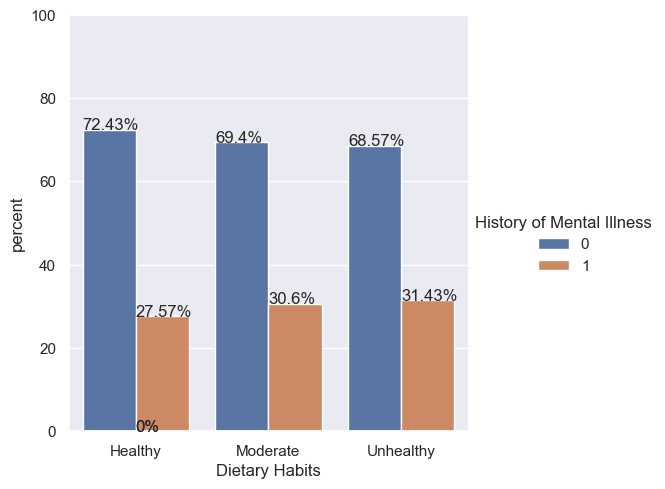

In [51]:
x,y = 'Dietary Habits', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# People with less than 4 children  have higher chances of having  mental illness

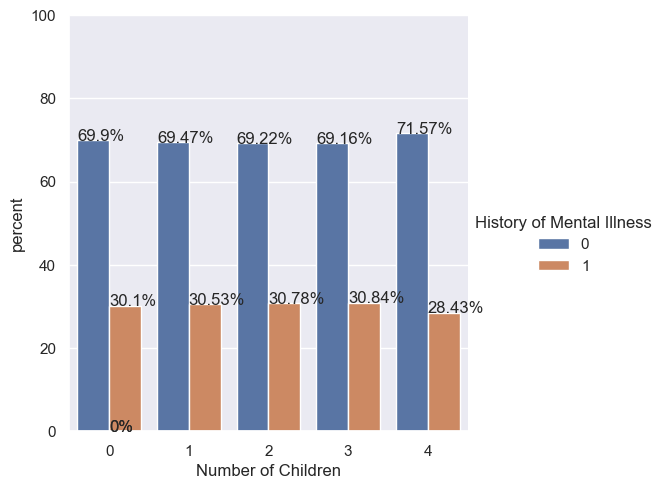

In [53]:
x,y = 'Number of Children', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [54]:
smoking_status=pd.DataFrame(df['Smoking Status'].value_counts())
smoking_status.rename_axis('Smoking Status',inplace=True)
smoking_status.columns=['Total Count']
smoking_status= smoking_status.reset_index()
smoking_status

,Smoking Status,Total Count
0,Non-smoker,247416
1,Former,116184
2,Current,50168


# The population comprises of more individuals with no children than others 

In [56]:
Number_of_Children=pd.DataFrame(df['Number of Children'].value_counts())
Number_of_Children.rename_axis('Number of Children', inplace=True)  
Number_of_Children.columns = ['Father or Mother ']
Number_of_Children= Number_of_Children.reset_index()
Number_of_Children

,Number of Children,Father or Mother
0,0,155232
1,2,83961
2,1,83925
3,3,76974
4,4,13676


# We have more data points where education level is Bachelor's Degree and High school

In [58]:
Education_Level=pd.DataFrame(df['Education Level'].value_counts())
Education_Level.rename_axis('Education Level',inplace=True)
Education_Level.columns=['Total Count']
Education_Level=Education_Level.reset_index()
Education_Level

,Education Level,Total Count
0,Bachelor's Degree,124329
1,High School,118927
2,Associate Degree,79999
3,Master's Degree,73768
4,PhD,16745


# Associate degree individuals are more likely to have mental illness

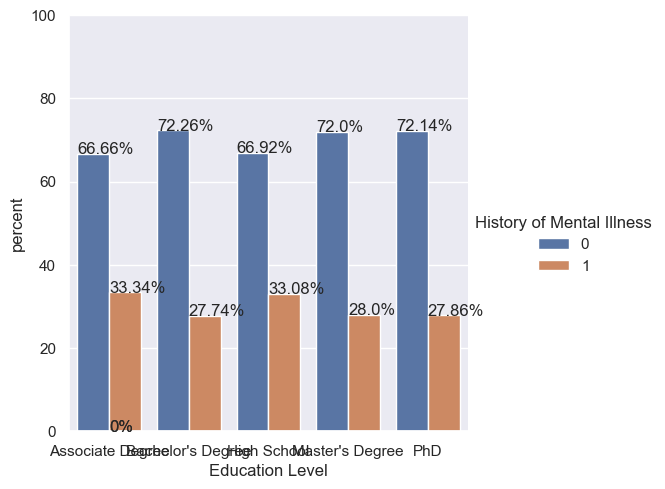

In [60]:
x,y = 'Education Level', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# People with history of depression seems like no direct relationship to hving mental illness

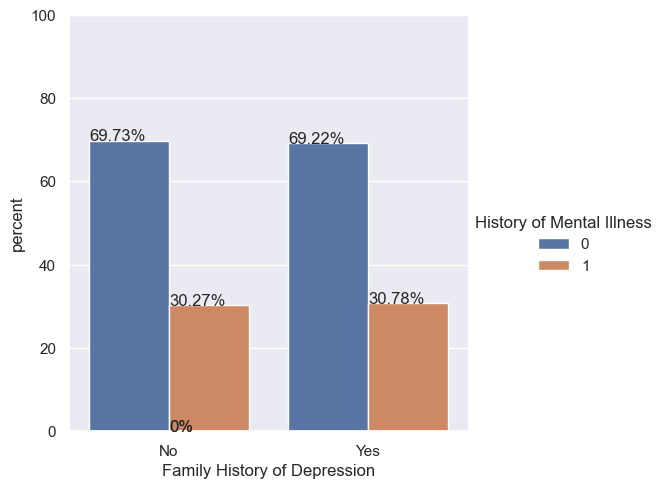

In [62]:
x,y = 'Family History of Depression', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# Total count of People not having chronic medical conditions is twice that of having chronic medical condition 

In [64]:
Medical_condition=pd.DataFrame(df['Chronic Medical Conditions'].value_counts())
Medical_condition.rename_axis('Chronic Medical Conditions',inplace=True)
Medical_condition.columns=['Total Count']
Medical_condition=Medical_condition.reset_index()
Medical_condition

,Chronic Medical Conditions,Total Count
0,No,277561
1,Yes,136207


# Chronic medical condition may not be the right feature to predict mental illness

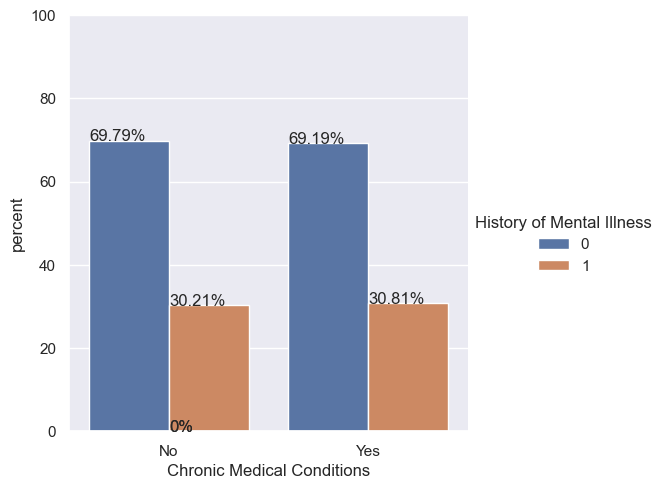

In [66]:
x,y = 'Chronic Medical Conditions', 'History of Mental Illness'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(round(p.get_height(),2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [67]:
Married_Education = df.groupby(['Marital Status','Education Level'])['Marital Status'].count().reset_index(name = 
                                                                                        'Count Of Married or Unmarried')
Married_Education

,Marital Status,Education Level,Count Of Married or Unmarried
0,Divorced,Associate Degree,6661
1,Divorced,Bachelor's Degree,9812
2,Divorced,High School,8193
3,Divorced,Master's Degree,6455
4,Divorced,PhD,1608
5,Married,Associate Degree,47535
6,Married,Bachelor's Degree,73573
7,Married,High School,62126
8,Married,Master's Degree,46194
9,Married,PhD,11016


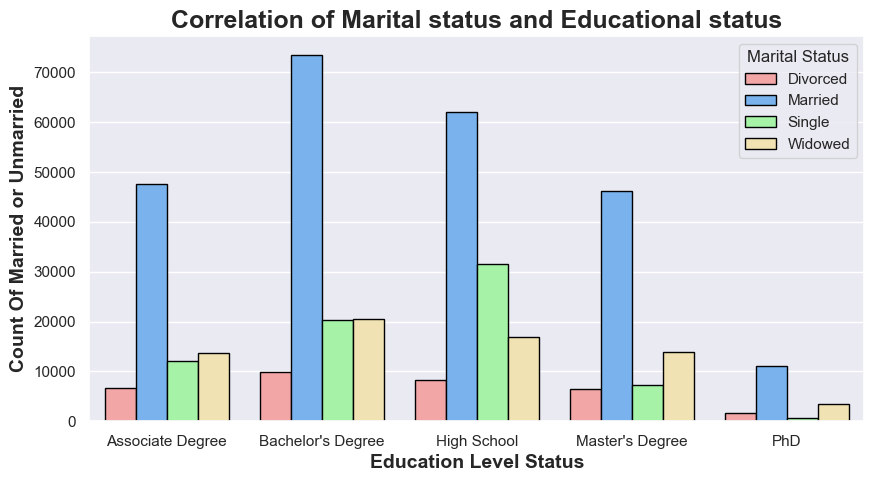

In [68]:
fig, ax = plt.subplots(figsize= (10,5))
sns.barplot(x = 'Education Level', y = 'Count Of Married or Unmarried',data = Married_Education,palette= 
            ['#FF9999', '#66B2FF', '#99FF99','#fbe7aa'], edgecolor='black',
 hue = 'Marital Status')
plt.title('Correlation of Marital status and Educational status',fontsize=18,weight='bold')
plt.xlabel('Education Level Status',fontsize=14,weight='bold')
plt.ylabel('Count Of Married or Unmarried',fontsize=14,weight='bold')
plt.show()

# People with higher education can have potential to earn more 

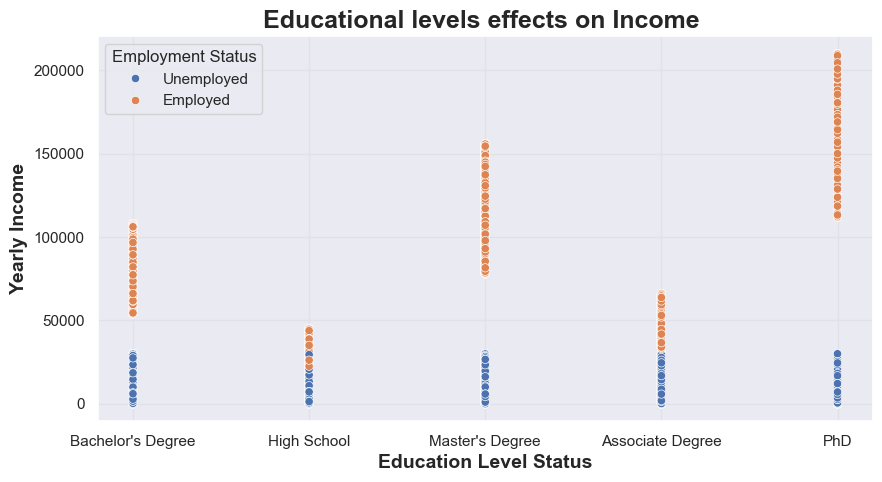

In [70]:
fig, ax = plt.subplots(figsize= (10,5))
sns.scatterplot(x = 'Education Level',y = 'Income',data = df.sort_values(by = []), hue = 'Employment Status' )
plt.title('Educational levels effects on Income ',fontsize=18,weight='bold')
plt.xlabel('Education Level Status',fontsize=14,weight='bold')
plt.ylabel('Yearly Income',fontsize=14,weight='bold')
plt.grid(color='#e2e2e6')
plt.show()

# Label Encoding all categorical columns values to unique numerical identifier

In [72]:
from wolta.data_tools import col_types
from wolta.data_tools import make_numerics
types = col_types(df, print_columns=True)
types = col_types(df)
loc = 0
for col in df.columns:
    if types[loc] == 'str':
        df[col] = make_numerics(df[col])
    loc += 1

Age: int64
Marital Status: str
Education Level: str
Number of Children: int64
Smoking Status: str
Physical Activity Level: str
Employment Status: str
Income: float64
Alcohol Consumption: str
Dietary Habits: str
Sleep Patterns: str
History of Mental Illness: int64
History of Substance Abuse: str
Family History of Depression: str
Chronic Medical Conditions: str
Income_Range: str
Age_bin: str


# Convert categorical column datatypes to category and encoding its values

In [74]:
df[['Marital Status','Education Level','Number of Children','Smoking Status','Physical Activity Level','Employment Status',
    'Alcohol Consumption','Dietary Habits','Sleep Patterns','History of Mental Illness','History of Substance Abuse',
  'Family History of Depression', 'Chronic Medical Conditions', 'Income_Range','Age_bin']].apply(lambda x: x.astype('category'))

types = col_types(df, print_columns=False)
types = col_types(df)
loc = 0
for col in df.columns:
    if types[loc] == 'str':
        df[col] = make_numerics(df[col])
    loc += 1

In [ ]:
X = df.drop('History of Mental Illness', axis=1)
Y = df['History of Mental Illness']
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=100,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')

model=XGBClassifier(n_estimators=100,learning_rate=0.1,enable_categorical=True)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()



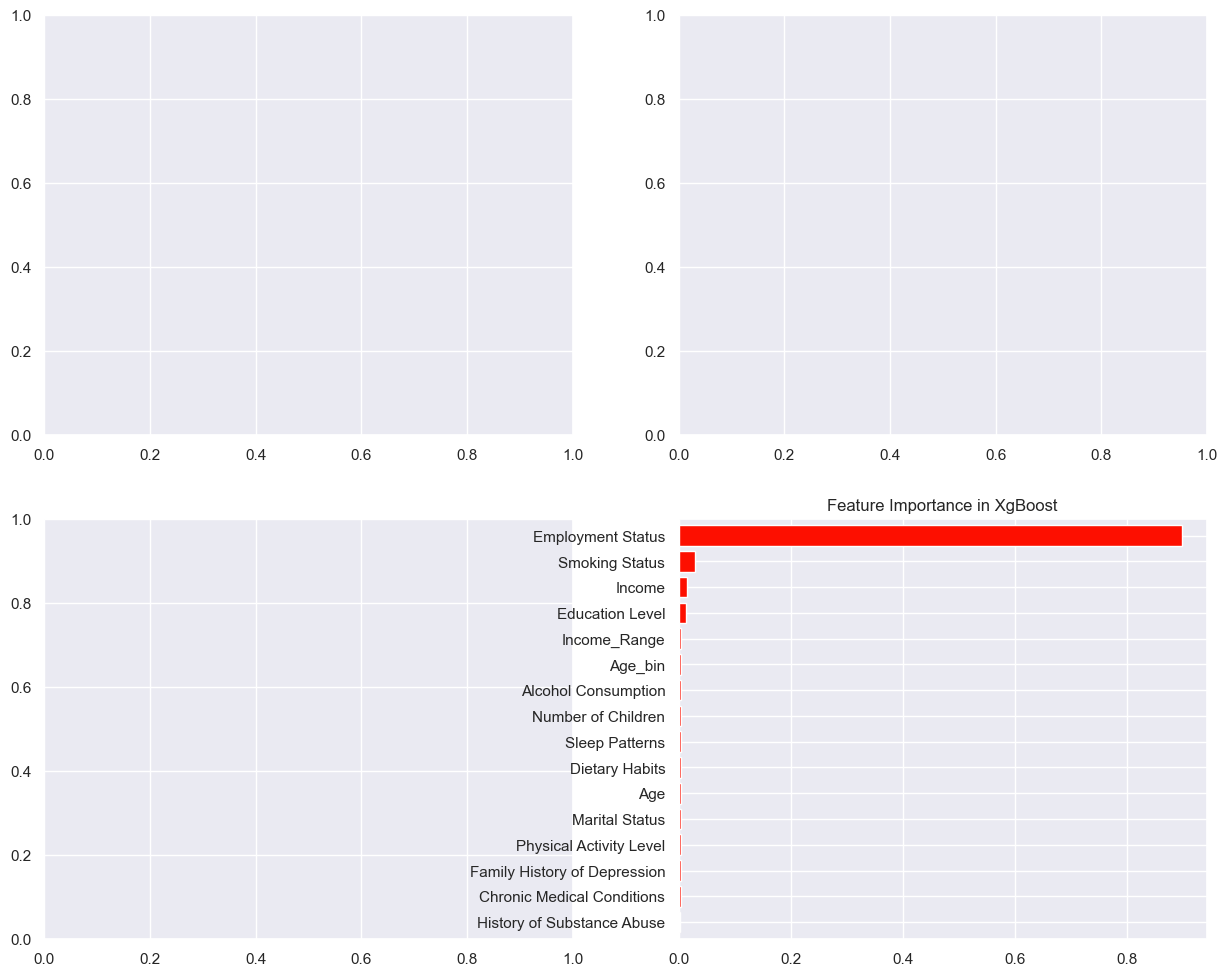

In [76]:
X = df.drop('History of Mental Illness', axis=1)
Y = df['History of Mental Illness']
f,ax=plt.subplots(2,2,figsize=(15,12))
model=XGBClassifier(n_estimators=100,learning_rate=0.1,enable_categorical=True)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

# The difference between these two features Income and Age is statistically significant 

In [83]:
from scipy.stats import spearmanr
#calculate Spearman Rank correlation and corresponding p-value(should be less than 0.05 to be statistically significant)
rho, p = spearmanr(df['Income'], df['Age'])
#print Spearman rank correlation and p-value
print('spearman relationship score:',rho)
print('The p value is:',p)

spearman relationship score: -0.12088665129874963
The p value is: 0.0
